## Analysis for Cortical Cell Images

A comprehensive workflow for enhancing microscopy images of cortical cells and performing FFT analysis on them.

Developed by: 
Roberto dos Reis, PhD - Northwestern Univeristy/2025 

roberto.reis@northwestern.edu

and

Paloma Lee - Northwestern University/2025

palomalee2025@u.northwestern.edu


This notebook is part of the paper entitled:
(TBD)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, exposure
from pathlib import Path

import ncempy.io as nio

from scipy.ndimage import median_filter
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.patches import Rectangle
from matplotlib_scalebar.scalebar import ScaleBar


## Load and Display the Original Image

First, let's load the image and examine it.

In [57]:
# file_path = 'selected_images/2024-07-11_3200_Wool_Devon/Devon_5E w UA -EtOH_20kX_0031.dm4' #linear
file_path = 'selected_images/Devon_5E w UA -EtOH_20kX_0032.dm4' #linear
 
# file_path = 'selected_images/Devon_5E w UA -EtOH_20kX_0013.dm4' #circular
# file_path = 'selected_images/Devon_5E w UA -EtOH_20kX_0021.dm4' #circular
# file_path = 'selected_images/Devon_5E w UA -EtOH_20kX_0022.dm4' #circular

# file_path = 'selected_images/Devon_5E w UA -EtOH_20kX_0034.dm4' #hex
# file_path = 'selected_images/Devon_5E w UA -EtOH_20kX_0035.dm4' #hex


In [ ]:
# # Replace with the path to your image for a png/tiff image
# image_path = 'images/B_nonmag.png'

# # Load the image
# try:
#     img = load_image(image_path)
#     display_image(img, 'Original Image')
# except FileNotFoundError:
#     print("Please update the image_path variable with the correct path to your image.")
#     # You can also use a sample image for testing
#     # from skimage import data
#     # img = data.camera()
#     # display_image(img, 'Sample Test Image')

In [58]:
def load_dm4(file_path):
    dmData = nio.read(file_path)
    return dmData

im_data= load_dm4(file_path)

print(im_data['data'].shape) # the shape of the data
print(im_data['pixelSize']) # print the pixel size

img = im_data['data']
scale = im_data['pixelSize']

(3838, 3710)
[0.18341091, 0.18341091]


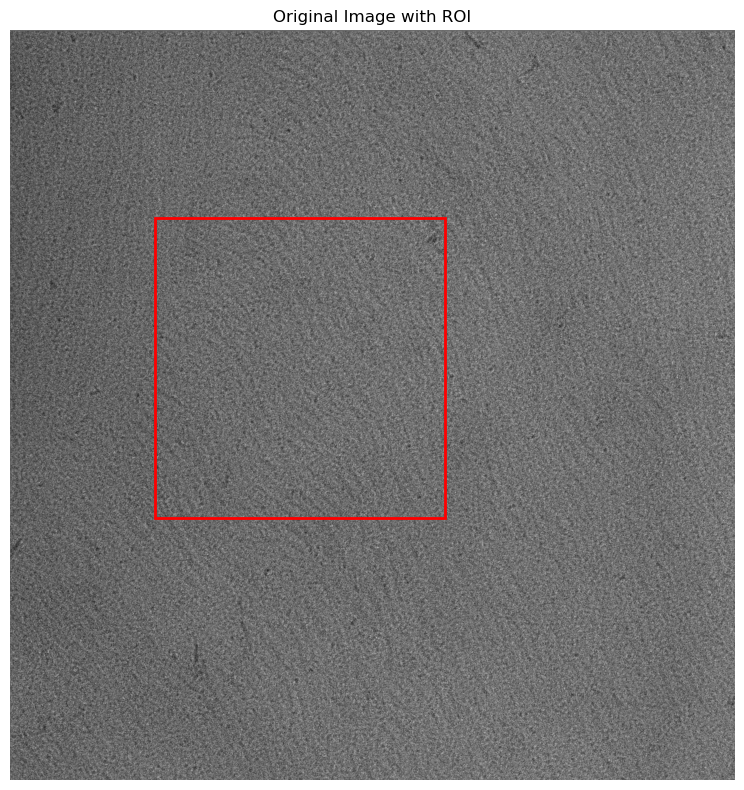

In [59]:
# Crop the image to focus on the region of interest
# Adjust these values based on your specific image
height, width = img.shape
crop_top = int(height * 0.25)  # Crop 10% from top
crop_bottom = int(height * 0.65)  # Keep up to 90% of height
crop_left = int(width * 0.2)  # Crop 10% from left
crop_right = int(width * 0.6)  # Keep up to 90% of width

img_crop = img[crop_top:crop_bottom, crop_left:crop_right]
# Display the cropped region overlaid on the original image
plt.figure(figsize=(10, 8))
plt.imshow(im_data['data'], cmap='gray')
plt.title('Original Image with ROI')

# Create a rectangle patch for the ROI
roi_rect = Rectangle((crop_left, crop_top), 
                     crop_right - crop_left, 
                     crop_bottom - crop_top,
                     linewidth=2, 
                     edgecolor='r', 
                     facecolor='none')

# Add the rectangle to the plot
plt.gca().add_patch(roi_rect)

plt.axis('off')
plt.tight_layout()
plt.show()


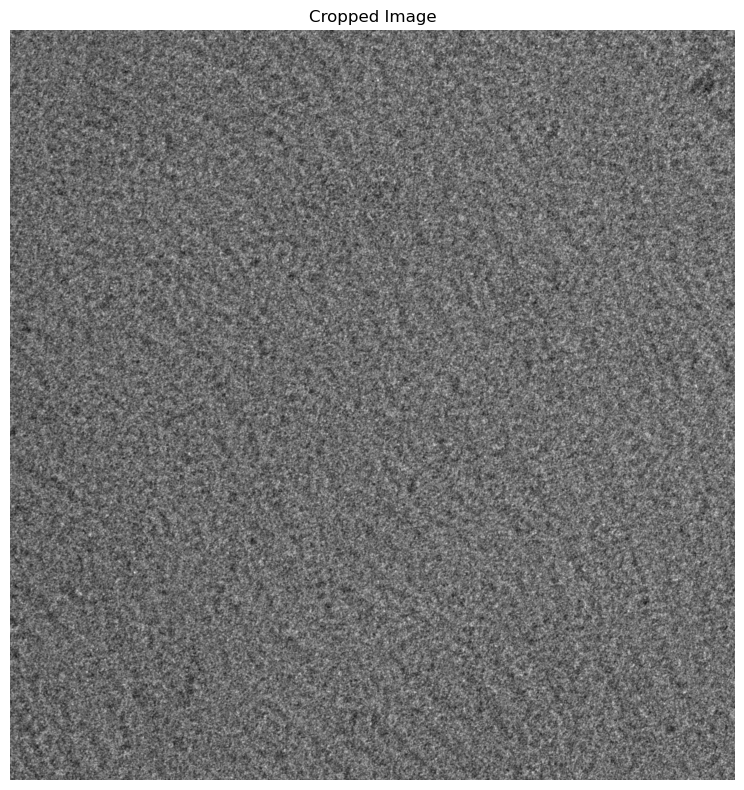

In [60]:
# Plot the cropped image
plt.figure(figsize=(8, 8))
plt.imshow(img_crop, cmap='gray')
plt.title('Cropped Image')
plt.axis('off')
plt.tight_layout()
plt.show()


## Step 1: Image Pre-processing

Let's apply several pre-processing steps to enhance the image quality before FFT analysis.

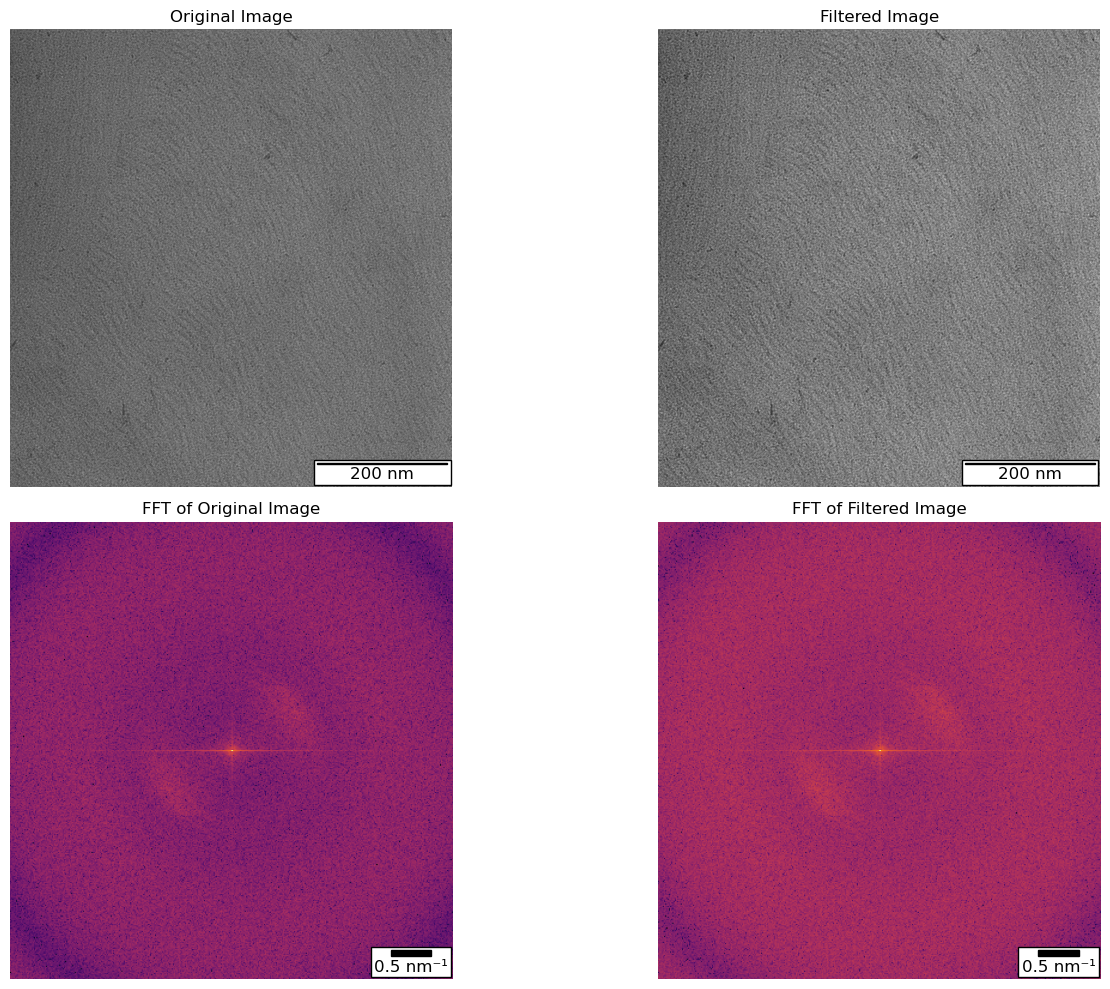

In [61]:
# Apply median filter
img_median = median_filter(img, size=5)

# Calculate FFT with proper shifting
fft_original = np.fft.fftshift(np.fft.fft2(img))
fft_filtered = np.fft.fftshift(np.fft.fft2(img_median))

# Direct undistortion approach - use original FFT as a template
def undistort_fft_direct(filtered_fft, original_fft):
    """
    Directly undistort FFT by using the original FFT as a template
    This preserves the key frequency components while reducing noise
    """
    # Get magnitudes
    mag_orig = np.abs(original_fft)
    mag_filt = np.abs(filtered_fft)
    
    # Find the peaks in the original FFT (these are the key frequency components)
    # We'll use a simple threshold approach
    threshold = np.percentile(mag_orig, 60)  # Top 1% of values
    peak_mask = mag_orig > threshold
    
    # Create a new FFT that preserves these key components
    # Start with the filtered FFT
    undistorted_fft = filtered_fft.copy()
    
    # At peak locations, use the phase from the original FFT
    # This preserves the spatial relationships
    undistorted_fft[peak_mask] = mag_filt[peak_mask] * np.exp(1j * np.angle(original_fft[peak_mask]))
    
    # For the rest, apply a smoothing filter to reduce noise
    h, w = filtered_fft.shape
    y, x = np.ogrid[-h//2:h//2, -w//2:w//2]
    mask = np.exp(-(x*x + y*y) / (2*(min(h, w)/30)**2))
    
    # Apply the mask only to non-peak areas
    non_peak_mask = ~peak_mask
    undistorted_fft[non_peak_mask] = filtered_fft[non_peak_mask] * mask[non_peak_mask]
    
    return undistorted_fft

# Apply the direct undistortion
fft_filtered_undistorted = undistort_fft_direct(fft_filtered, fft_original)

# Calculate magnitude and apply log scaling
mag_orig = np.log1p(np.abs(fft_original))
mag_filt = np.log1p(np.abs(fft_filtered))
mag_filt_undistorted = np.log1p(np.abs(fft_filtered_undistorted))

# Crop FFT to central portion (5%)
crop_factor = 0.05
h, w = mag_orig.shape
crop_h, crop_w = int(h * crop_factor), int(w * crop_factor)
center_h, center_w = h // 2, w // 2

mag_orig_crop = mag_orig[center_h - crop_h:center_h + crop_h, 
                         center_w - crop_w:center_w + crop_w]
mag_filt_crop = mag_filt[center_h - crop_h:center_h + crop_h, 
                         center_w - crop_w:center_w + crop_w]
mag_filt_undistorted_crop = mag_filt_undistorted[center_h - crop_h:center_h + crop_h, 
                                                center_w - crop_w:center_w + crop_w]

# Create a figure with 2x2 subplots to include the undistorted FFT
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Display original image
axs[0, 0].imshow(img, cmap='gray')
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

# Display filtered image
axs[0, 1].imshow(img_median, cmap='gray')
axs[0, 1].set_title('Filtered Image')
axs[0, 1].axis('off')

# # Empty subplot for symmetry
# axs[0, 2].axis('off')

# Display cropped FFT of original image
axs[1, 0].imshow(mag_orig_crop, cmap='inferno')
axs[1, 0].set_title('FFT of Original Image')
axs[1, 0].axis('off')

# Display cropped FFT of filtered image
axs[1, 1].imshow(mag_filt_undistorted_crop, cmap='inferno')
axs[1, 1].set_title('FFT of Filtered Image')
axs[1, 1].axis('off')

# # Display cropped FFT of undistorted filtered image
# axs[1, 2].imshow(mag_filt_undistorted_crop, cmap='inferno')
# axs[1, 2].set_title('Undistorted FFT of Filtered Image')
# axs[1, 2].axis('off')

# Add scale bars to real-space images using pixelSize calibration
fontprops = fm.FontProperties(size=12)
scalebar_length_nm = 200  # length in nm
scalebar_length_px = scalebar_length_nm / scale[0]  # convert to pixels

for ax in [axs[0, 0], axs[0, 1]]:
    scalebar = AnchoredSizeBar(ax.transData,
                              scalebar_length_px,
                              f'{scalebar_length_nm} nm',
                              'lower right',
                              pad=0.2,
                              color='k',
                              frameon=True,
                              size_vertical=5,
                              fontproperties=fontprops)
    ax.add_artist(scalebar)

# Calculate the FFT scale - reciprocal of real space scale
# The FFT frequency scale is in units of cycles per pixel
# To convert to nm^-1, we need to multiply by pixels per nm
pixel_per_nm = 1.0 / scale[0]

# For the cropped FFT, we need to adjust the scale
# The frequency spacing in the FFT is 1/N where N is the image dimension
freq_spacing_x = 1.0 / w  # cycles per pixel
freq_spacing_y = 1.0 / h  # cycles per pixel

# Convert to nm^-1
freq_spacing_x_nm = freq_spacing_x * pixel_per_nm  # cycles per nm = nm^-1
freq_spacing_y_nm = freq_spacing_y * pixel_per_nm  # cycles per nm = nm^-1

# Calculate a reasonable scale bar length for FFT images
# We want a round number in reciprocal space
fft_scalebar_length_nm_inv = 0.5  # length in nm^-1
fft_scalebar_length_px = fft_scalebar_length_nm_inv / freq_spacing_x_nm  # convert to pixels

# For the cropped FFT, adjust the scale bar length
crop_scale_factor = crop_factor * 2  # we're showing a region that's crop_factor*2 of the full FFT
fft_scalebar_length_px_crop = fft_scalebar_length_px * crop_scale_factor

# Add scale bars to FFT images
for ax in [axs[1, 0], axs[1, 1]]:
    fft_scalebar = AnchoredSizeBar(ax.transData,
                                  fft_scalebar_length_px_crop,
                                  f'{fft_scalebar_length_nm_inv} nm⁻¹',
                                  'lower right',
                                  pad=0.2,
                                  color='k',
                                  frameon=True,
                                  size_vertical=5,
                                  fontproperties=fontprops)
    ax.add_artist(fft_scalebar)

plt.tight_layout()
plt.savefig('em_image_analysis_with_fft.png', dpi=300, bbox_inches='tight')
plt.show()